In [96]:
import pandas as pd
from keras.legacy_tf_layers.core import Dropout

# Gather both datasets
pv_df = pd.read_excel("AA.Sakakah 2021 PV supply dataset.xlsx")
weather_df = pd.read_csv("AA.Sakakah 2021 weather dataset.csv", skiprows = 16)

# Adjusting Tables & Merging

In [97]:
# Combine Year Month Day Hour into one string and then turn that object into a date & time object
weather_df["DATE & TIME"] = pd.to_datetime(weather_df["YEAR"].astype(str) + "-" +
                                    weather_df["MO"].astype(str).str.zfill(2) + "-" +
                                    weather_df["DY"].astype(str).str.zfill(2) + " " +
                                    weather_df["HR"].astype(str) + ":00")

# Drop the previous date and hour columns
weather_df = weather_df.drop(columns=["YEAR", "MO", "DY", "HR"], axis=1)

# Moving DATE column to the front of the dataset
weather_df = weather_df[["DATE & TIME"] + [col for col in weather_df.columns if col != "DATE & TIME"]]

# Merging Weather dataset & PV Supply dataset
df = pd.merge(weather_df, pv_df, left_on = "DATE & TIME", right_on = "Date & Time", how = "inner")
df.drop(columns =["Date & Time"], inplace = True)

# Renaming Columns for easier understandability
df.rename(columns = {
    "ALLSKY_SFC_SW_DWN" : "Solar Radiation (Wh/m)2",
    "ALLSKY_SFC_UV_INDEX" : "UV Intensity",
    "ALLSKY_KT" : "Atmospheric Clarity",
    "T2M" : "Temperature (2m)",
    "QV2M" : "Humidity (2M)",
    "WS10M" : "Wind Speed (10m)",
    "WD10M" : "Wind Direction (10m)",
    "MW" : "MW Supply",
}, inplace = True)
print(df.columns.tolist())
df.head(500)

['DATE & TIME', 'Solar Radiation (Wh/m)2', 'UV Intensity', 'Atmospheric Clarity', 'Temperature (2m)', 'Humidity (2M)', 'PS', 'Wind Speed (10m)', 'Wind Direction (10m)', 'MW Supply']


,DATE & TIME,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Supply
0,2021-01-01 00:00:00,0.00,0.00,-999.00,8.03,6.65,93.99,3.62,85.05,0
1,2021-01-01 01:00:00,0.00,0.00,-999.00,8.01,6.65,94.00,3.50,91.92,0
2,2021-01-01 02:00:00,0.00,0.00,-999.00,8.03,6.65,94.00,3.41,98.58,0
3,2021-01-01 03:00:00,0.00,0.00,-999.00,8.01,6.59,93.98,3.33,101.65,0
4,2021-01-01 04:00:00,0.00,0.00,-999.00,7.92,6.59,93.98,3.26,104.87,0
...,...,...,...,...,...,...,...,...,...,...
495,2021-01-21 15:00:00,384.79,1.20,0.67,10.35,1.95,94.75,3.46,4.27,252
496,2021-01-21 16:00:00,210.72,0.25,0.62,9.12,2.08,94.76,2.88,6.70,96
497,2021-01-21 17:00:00,34.77,0.02,0.48,5.26,2.56,94.79,2.43,17.79,68
498,2021-01-21 18:00:00,0.00,0.00,-999.00,3.65,2.26,94.84,2.67,28.29,0


# Preprocess The Data

In [98]:
# Check for any values that seem suspicious
print(df.describe())
print(df["UV Intensity"].describe())


               DATE & TIME  Solar Radiation (Wh/m)2  UV Intensity  \
count                 8760              8760.000000   8760.000000   
mean   2021-07-02 11:30:00               256.200756    -33.227892   
min    2021-01-01 00:00:00                 0.000000   -999.000000   
25%    2021-04-02 05:45:00                 0.000000      0.000000   
50%    2021-07-02 11:30:00                12.115000      0.000000   
75%    2021-10-01 17:15:00               528.965000      2.380000   
max    2021-12-31 23:00:00              1048.840000     12.980000   
std                    NaN               336.004098    183.773540   

       Atmospheric Clarity  Temperature (2m)  Humidity (2M)           PS  \
count          8760.000000       8760.000000    8760.000000  8760.000000   
mean           -483.551551         22.139564       4.601881    93.487983   
min            -999.000000         -4.170000       0.920000    92.430000   
25%            -999.000000         13.060000       3.660000    93.100000  

UV and Atmosphere have min or 25% at -999.0
- This tells me that there are missing or unresolved values in the dataset <br>

## Handling Missing Values

In [99]:
# See how many missing values are missing from columns affected
missing_values_UV = (df["UV Intensity"] == -999.0).sum()
missing_values_AtmoClar = (df["Atmospheric Clarity"] == -999.0).sum()
print(f"Number of -999 values in UV Intensity: {missing_values_UV}" + " / 8760")
print(f"Number of -999 values in Atmospheric Clarity: {missing_values_AtmoClar}" + " / 8760")

Number of -999 values in UV Intensity: 306 / 8760
Number of -999 values in Atmospheric Clarity: 4243 / 8760


UV Intensity & Atmospheric Clarity / Replace = Interpolate <br>
(Interpolate - assigns NaN for the -999 and then uses nearby values to continue temporal trends in the dates) <br>
- Due to the fact that both of these columns are influenced by the time of day I can not just use the medium as it runs the risk of having values go up when it wouldn't make sense, referring to the time of day

UV Intensity After Interpolation:
count    8760.000000
mean        1.837475
std         3.007287
min         0.000000
25%         0.000000
50%         0.020000
75%         2.824167
max        12.980000
Name: UV Intensity, dtype: float64

Atmospheric Clarity After Interpolation:
count    8760.000000
mean        0.511485
std         0.171793
min         0.060000
25%         0.371538
50%         0.453636
75%         0.692500
max         0.840000
Name: Atmospheric Clarity, dtype: float64


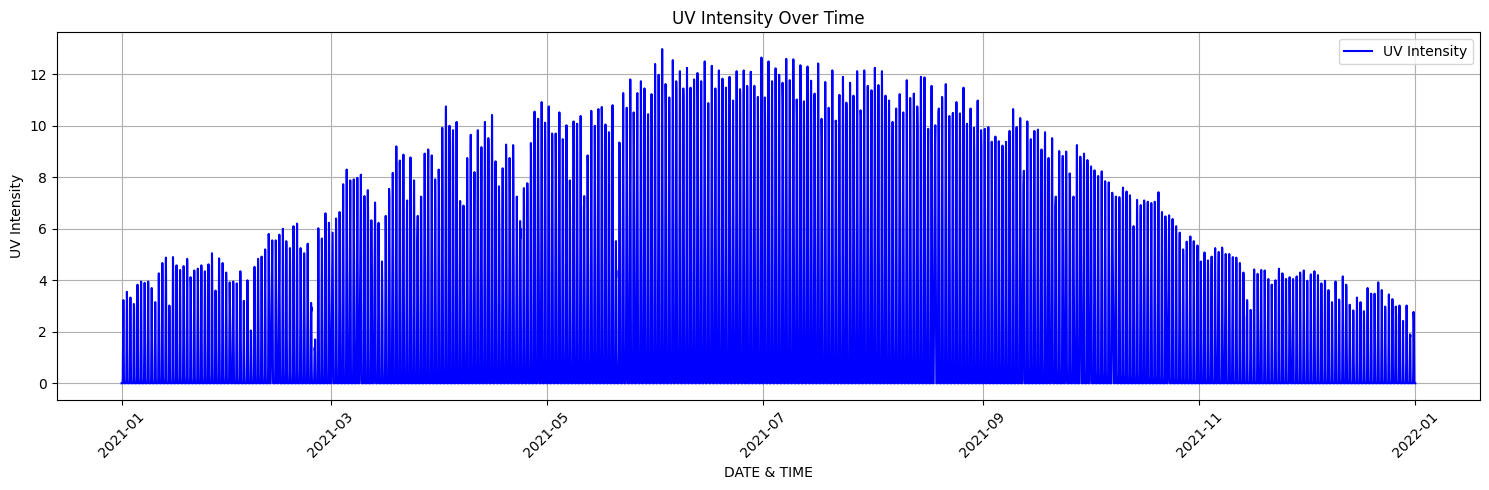

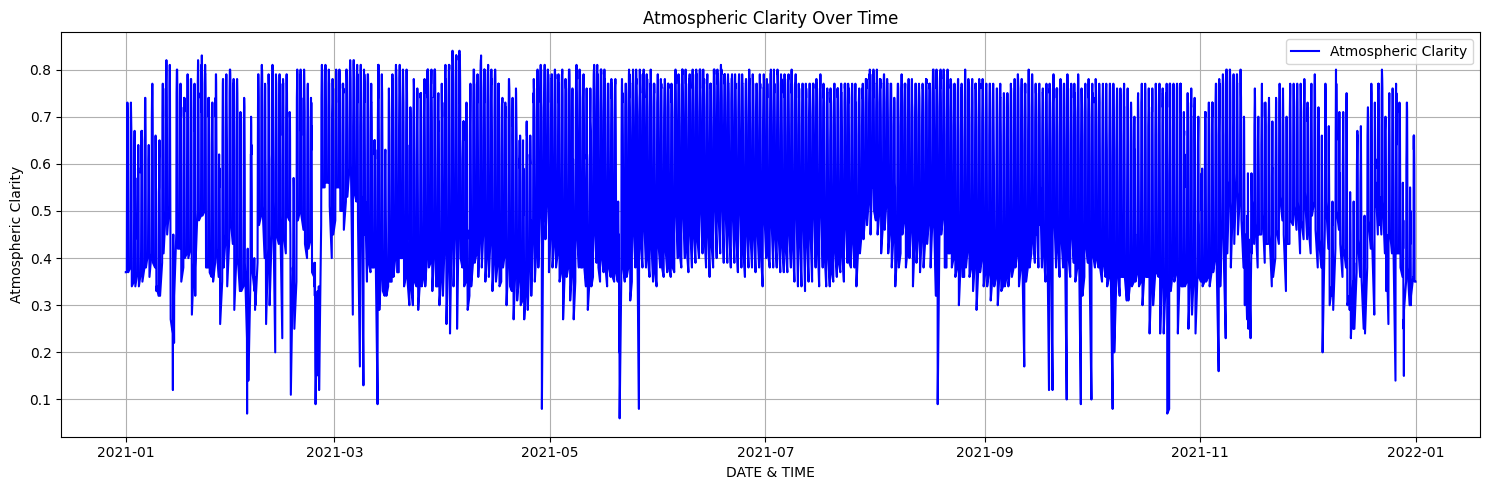

,DATE & TIME,Solar Radiation (Wh/m)2,UV Intensity,Atmospheric Clarity,Temperature (2m),Humidity (2M),PS,Wind Speed (10m),Wind Direction (10m),MW Supply
0,2021-01-01 00:00:00,0.0,0.0,0.370000,8.03,6.65,93.99,3.62,85.05,0
1,2021-01-01 01:00:00,0.0,0.0,0.370000,8.01,6.65,94.00,3.50,91.92,0
2,2021-01-01 02:00:00,0.0,0.0,0.370000,8.03,6.65,94.00,3.41,98.58,0
3,2021-01-01 03:00:00,0.0,0.0,0.370000,8.01,6.59,93.98,3.33,101.65,0
4,2021-01-01 04:00:00,0.0,0.0,0.370000,7.92,6.59,93.98,3.26,104.87,0
...,...,...,...,...,...,...,...,...,...,...
95,2021-01-04 23:00:00,0.0,0.0,0.352857,10.65,6.71,94.16,3.85,100.53,0
96,2021-01-05 00:00:00,0.0,0.0,0.355000,10.35,6.65,94.11,3.80,102.69,0
97,2021-01-05 01:00:00,0.0,0.0,0.357143,9.70,6.59,94.08,3.30,104.70,0
98,2021-01-05 02:00:00,0.0,0.0,0.359286,9.70,6.53,94.09,3.14,104.87,0


In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Replace -999 with NaN in both columns
df["UV Intensity"] = df["UV Intensity"].replace(-999.0, np.nan)
df["Atmospheric Clarity"] = df["Atmospheric Clarity"].replace(-999.0, np.nan)

# Linear interpolation in both directions
df["UV Intensity"] = df["UV Intensity"].interpolate(method = "linear", limit_direction = "both")
df["Atmospheric Clarity"] = df["Atmospheric Clarity"].interpolate(method = "linear", limit_direction = "both")

# Verify the changes after interpolation
print("UV Intensity After Interpolation:")
print(df["UV Intensity"].describe())

print("\nAtmospheric Clarity After Interpolation:")
print(df["Atmospheric Clarity"].describe())

# Graph to check for correct UV intensity over time
plt.figure(figsize = (15,5))
plt.plot(df["DATE & TIME"], df["UV Intensity"], color = "blue", label = "UV Intensity")
plt.title("UV Intensity Over Time")
plt.xlabel("DATE & TIME")
plt.ylabel("UV Intensity")
plt.xticks(rotation = 45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Graph to check for correct Atmospheric Clarity over time
plt.figure(figsize = (15,5))
plt.plot(df["DATE & TIME"], df["Atmospheric Clarity"], color = "blue", label = "Atmospheric Clarity")
plt.title("Atmospheric Clarity Over Time")
plt.xlabel("DATE & TIME")
plt.ylabel("Atmospheric Clarity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df.head(100)

# Save new folder
# df.to_csv("Clean Data.csv", index = False)

- UV Intensity --> I can see a clear increase in hot months and a decrease in the colder months
- Atmospheric Clarity --> I can see less clarity in the colder months and more clarity in the summer months which is correct

# Model Preparation
## Convert Date & Time Into Seconds (Continuous Data)

In [101]:
# Convert Date & Time into seconds as a timestamp
df["timestamp"] = df["DATE & TIME"].astype("int64") // 10**9 # Convert time into seconds
df.drop(columns = ["DATE & TIME"], inplace = True)

## Normalizing and Splitting Data

In [102]:
from sklearn.preprocessing import MinMaxScaler

x = df.drop(columns=["MW Supply"])
y = df["MW Supply"].values.reshape(-1, 1)

# Split 80% train+val and 20% test
train_size = int(0.8 * len(x))
val_size = int(0.1 * train_size)  # 10% of train+val as val

x_train_full, x_test = x[:train_size], x[train_size:]
y_train_full, y_test = y[:train_size], y[train_size:]

# Split train+val into train and val
x_train, x_val = x_train_full[:-val_size], x_train_full[-val_size:]
y_train, y_val = y_train_full[:-val_size], y_train_full[-val_size:]

# Scale using training data only
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

## Creating Sequence
Sequences are used to create sections of data <br>
Each sequence is a window of time, the size of this window is defined by a look back variable (in this case 24 hours)

In [103]:
def create_sequence(data, labels, look_back):
    sequences = []
    label_values = []

    # Convert Data to Numpy array
    data = data.values if isinstance(data, pd.DataFrame) else data
    labels = labels.values if isinstance(labels, pd.Series) else labels

    for i in range(len(data) - look_back):
        '''
        1. This looks at the first 24 values and then gives it the label 25
        2. Then starts at the second hour in the feature and then looks at the next 24 values and increments the label (in this case next label is 26)
        3. Putting it simple, each sequences loses the first hour (making the previous second hour the first) and then adds the hour after the
           previous sequence to be the last hour in the new sequence
        4. This repeats through the whole given dataset
        This splits the whole data set into 24 hour chunks going up by 1 hour for each sequence
        EXAMPLE:
           Context:
                - Hour 6 target Value = 4.3 MW
                - Hour 7 target Value = 5.2 MW
                - Number in [] are data from each feature (Simplified to normal numbers)
           look_back = 5
           SEQ.1 = [1, 2, 3, 4, 5] // Label = 4.3 MW (Next hour is 6 so label is hour 6 target value)
           SEQ.2 = [2 ,3, 4, 5, 6] // Label = 5.2 MW (Next hour is 7 so label is hour 7 target value)
        '''
        seq = data[i: i + look_back]  # Collect data for the look-back (past 24 hours of data)
        label = labels[i + look_back]  # Creates label by incrementally by 1 after each set of 24 hour

        sequences.append(seq)
        label_values.append(label)

    return (np.array(sequences),
            np.array(label_values).reshape(-1, 1))

look_back = 24  # look back at the past 24 hours

# Create sequences and labels for sets of 24 hour look backs for each dataset
'''
X vars are multiple dimension arrays (Holds the input features for each sequence)
Y vars are a single dimension array (Each label is the target value for each sequence)
First Sequence  (label = target value for hour 1)
Second Sequence (label = target value for hour 2)
etc...
'''
X_train_seq, y_train_seq = create_sequence(x_train_scaled, y_train_scaled, look_back)
X_val_seq, y_val_seq = create_sequence(x_val_scaled, y_val_scaled, look_back)
X_test_seq, y_test_seq = create_sequence(x_test_scaled, y_test_scaled, look_back)

# Output shapes of the datasets
print(f"Training    X sequences shape:  {X_train_seq.shape}\n"
      f"Training    Y sequences shape:  {y_train_seq.shape}\n"
      f"Validation  X sequences shape:  {X_val_seq.shape}\n"
      f"Validation  Y sequences shape:  {y_val_seq.shape}\n"
      f"Testing     X sequences shape:  {X_test_seq.shape}\n"
      f"Testing     Y sequences shape:  {y_test_seq.shape}")

# Check Y vars for correct data (Just going to check training data)
y_train_df = pd.DataFrame(y_train_seq)
y_train_df.head(100)

Training    X sequences shape:  (6284, 24, 9)
Training    Y sequences shape:  (6284, 1)
Validation  X sequences shape:  (676, 24, 9)
Validation  Y sequences shape:  (676, 1)
Testing     X sequences shape:  (1728, 24, 9)
Testing     Y sequences shape:  (1728, 1)


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
95,0.0
96,0.0
97,0.0
98,0.0


Dataset Sequence Shape:
- Value 1 --> Number of rows in the dataset
- Value 2 --> Value for the look back (24 hours)
- Value 3 --> Number of features:
    - ( X vars --> 9 features (minus target feature "Mega Watts"))
    - ( Y vars --> 1 feature (minus input features but only target feature)

# Create Long-Short Term Memory (LSTM) Neural Network

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create the layers
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dense(units = 1))

# .shape[1] --> look back (24 hours)
# .shape[2] --> number of features (9 features)

# Compile the model
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = "mse",
    metrics = ["mae"],
)

## Train The Model

In [105]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning Rate Scheduler --> Make sures the learning rate starts off high but then slows down when epochs see small important
LR_scheduler = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True)

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs = 50,
    validation_data = (X_val_seq, y_val_seq),
    callbacks = [early_stopping, LR_scheduler],
    verbose = 1
)

Epoch 1/50
197/197 [==============================] - 9s 28ms/step - loss: 0.0793 - mae: 0.3537 - val_loss: 0.0470 - val_mae: 0.2899 - lr: 1.0000e-04
Epoch 2/50
197/197 [==============================] - 4s 22ms/step - loss: 0.0272 - mae: 0.1935 - val_loss: 0.0239 - val_mae: 0.1667 - lr: 1.0000e-04
Epoch 3/50
197/197 [==============================] - 5s 23ms/step - loss: 0.0179 - mae: 0.1516 - val_loss: 0.0197 - val_mae: 0.1502 - lr: 1.0000e-04
Epoch 4/50
197/197 [==============================] - 5s 23ms/step - loss: 0.0165 - mae: 0.1439 - val_loss: 0.0160 - val_mae: 0.1328 - lr: 1.0000e-04
Epoch 5/50
197/197 [==============================] - 4s 22ms/step - loss: 0.0160 - mae: 0.1403 - val_loss: 0.0153 - val_mae: 0.1296 - lr: 1.0000e-04
Epoch 6/50
197/197 [==============================] - 4s 22ms/step - loss: 0.0154 - mae: 0.1376 - val_loss: 0.0157 - val_mae: 0.1292 - lr: 1.0000e-04
Epoch 7/50
197/197 [==============================] - 4s 21ms/step - loss: 0.0149 - mae: 0.1347 - va

# Evaluate The Model
Display RMAE


In [106]:
from sklearn.metrics import mean_absolute_error

# Predict on train, test, val sequences
y_train_pred_scaled = model.predict(X_train_seq)
y_test_pred_scaled = model.predict(X_test_seq)
y_val_pred_scaled = model.predict(X_val_seq)

# Inverse scale predictions and true values
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled)

y_train_true = y_scaler.inverse_transform(y_train_seq)
y_test_true = y_scaler.inverse_transform(y_test_seq)
y_val_true = y_scaler.inverse_transform(y_val_seq)

# Calculate MAE for each dataset
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)

# Calculate mean of true values (for relative error)
mean_train = np.mean(y_train_true)
mean_test = np.mean(y_test_true)
mean_val = np.mean(y_val_true)

# Calculate RMAE
rmae_train = mae_train / mean_train
rmae_test = mae_test / mean_test
rmae_val = mae_val / mean_val

print(f"Training RMAE: {rmae_train * 100:.2f}%")
print(f"Validation RMAE: {rmae_val* 100:.2f}%")
print(f"Testing RMAE: {rmae_test * 100:.2f}%")

22/22 [==============================] - 0s 7ms/step
Training RMAE: 19.14%
Validation RMAE: 28.28%
Testing RMAE: 52.06%


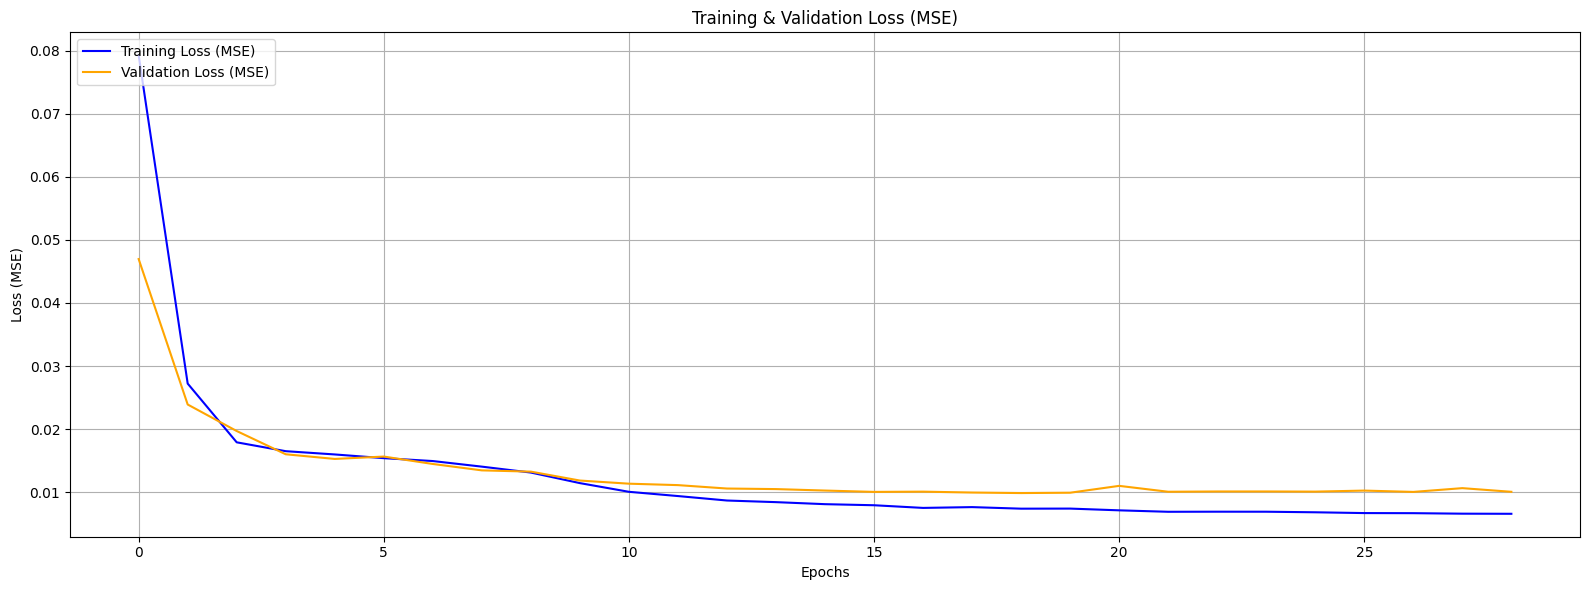

In [107]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_rmse = np.sqrt(training_loss)  # RMSE is the square root of the loss (MSE)
val_rmse = np.sqrt(val_loss)  # RMSE for validation

# Plot for Loss
plt.figure(figsize=(16, 6))
plt.plot(training_loss, label="Training Loss (MSE)", color="blue")
plt.plot(val_loss, label="Validation Loss (MSE)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss (MSE)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


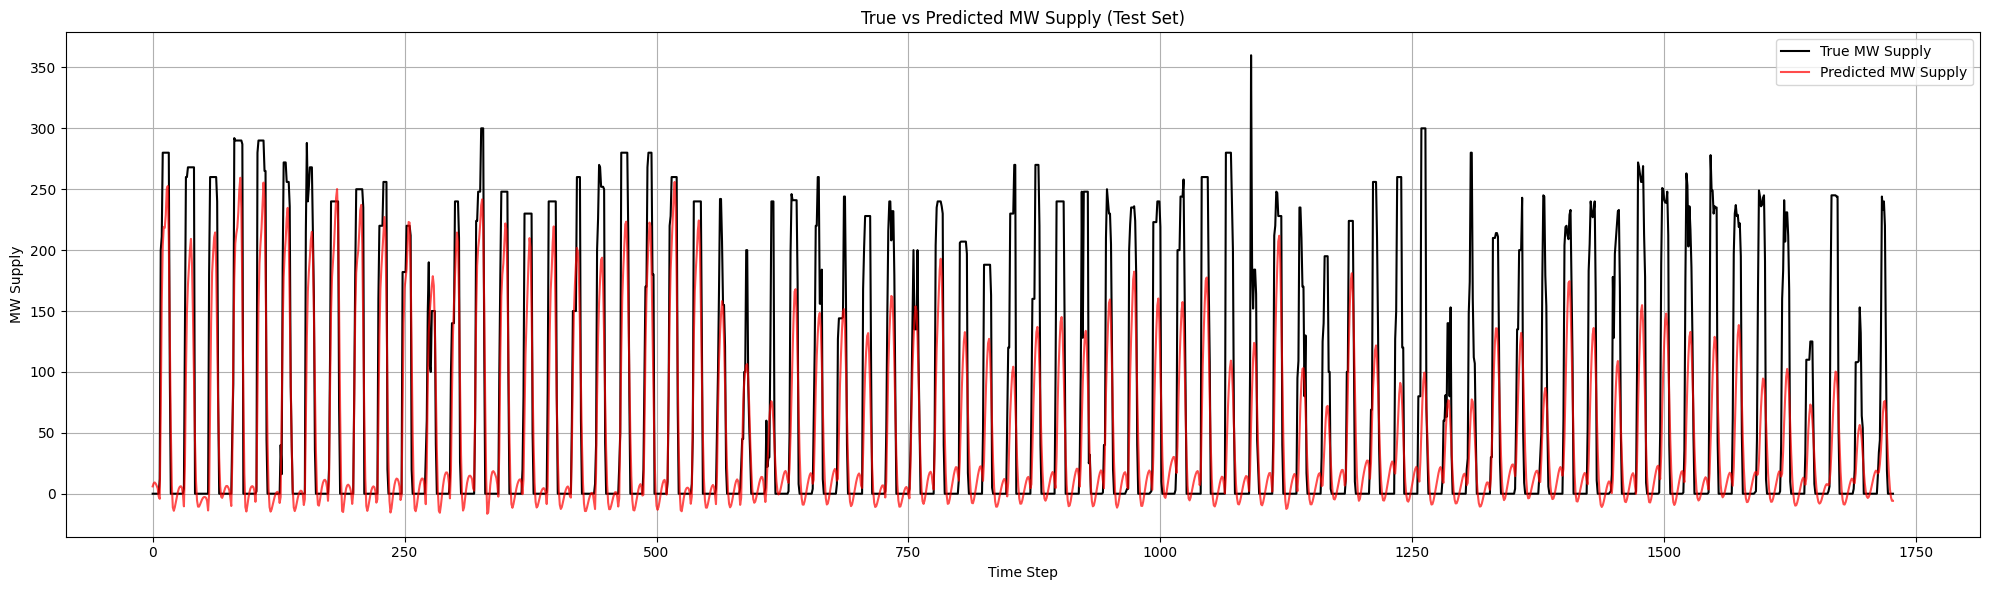

In [108]:
# Plot True vs Predicted for Test
plt.figure(figsize=(20, 6))
plt.plot(y_test_true, label="True MW Supply", color="black")
plt.plot(y_test_pred, label="Predicted MW Supply", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("MW Supply")
plt.title("True vs Predicted MW Supply (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()